In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [50]:
import random as ran
from IPython.display import clear_output
from src import spotify, dp, utils, DB
from sklearn.metrics.pairwise import euclidean_distances as euc
import pandas as pd
import math as mt
import numpy as np

db = DB()

# K Checking
- 새로운 K의 갯수를 만들 수 있는지 확인하는 과정

In [51]:
seed_musics = db.seed_zone.estimated_document_count()
K = round(mt.sqrt(seed_musics / 2))
print("현재 seed 음악 갯수 : {}".format(seed_musics))
print("K 갯수 : {}".format(K))

현재 seed 음악 갯수 : 301
K 갯수 : 12


In [52]:
_seed_features = db.seed_zone.find({})
seed_features = pd.DataFrame([_ for _ in _seed_features])

seed_features.drop(["_id"], axis=1, inplace=True)
seed_features.rename({"track_id": "id"}, axis=1,inplace=True)

seed_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,0.632,0.0378,5,-20.596,0.0583,0.9890,0.935000,0.1120,0.357,121.361
1,3UPjb91Fwm7u2tAm92Bk0p,0.554,0.5260,7,-5.210,0.0394,0.8080,0.000000,0.0740,0.230,129.845
2,3dbLT62Cvs46Ju7a8gpr36,0.727,0.8790,9,-1.167,0.1290,0.1240,0.000012,0.2440,0.671,146.959
3,2FWquqPNxte8iqZ3ATQG0p,0.403,0.7240,8,-6.064,0.2460,0.3770,0.000000,0.0927,0.428,97.133
4,3gzIK2dGSVvPBiohsTwEWZ,0.639,0.5690,0,-7.236,0.0487,0.0581,0.000169,0.1080,0.616,142.967


# Make Norm Features

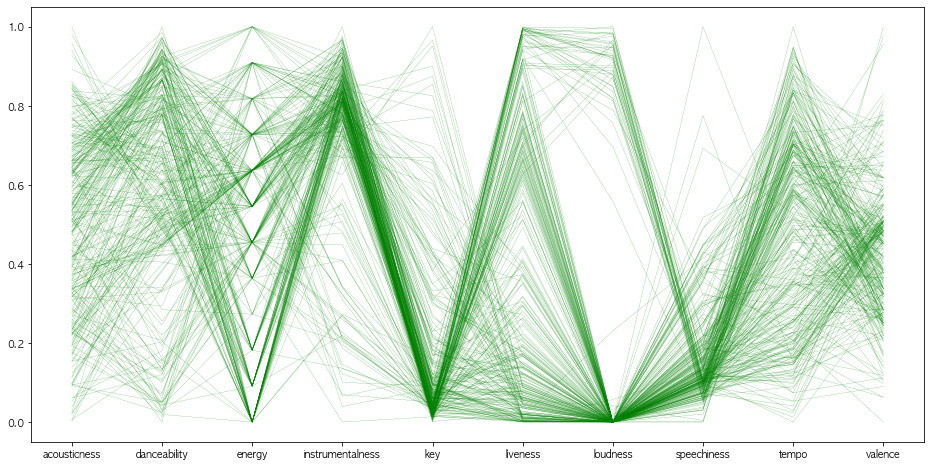

In [53]:
norm_features = dp.make_norm(seed_features)

utils.visual_norm_data(None, norm_features)

# KMeans Run

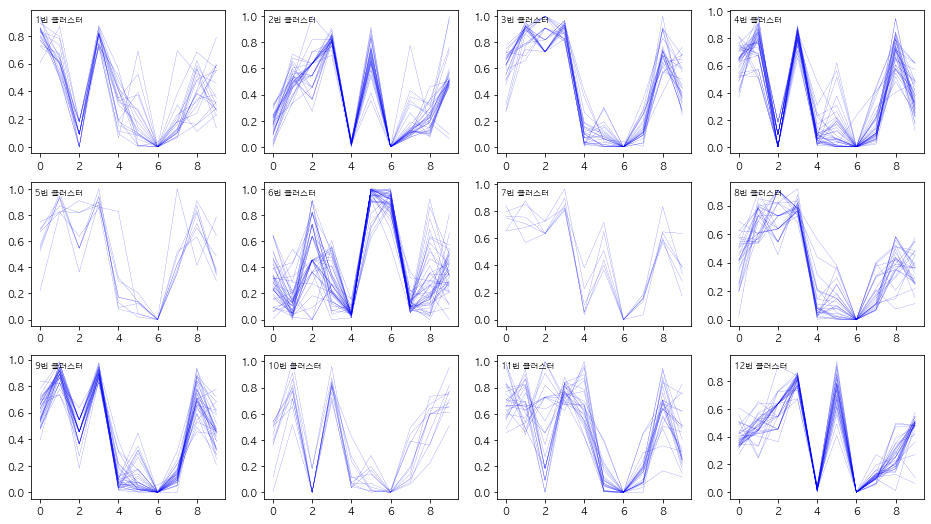

In [54]:
kmeans = utils.KMeans(
    datas=norm_features
)
kmeans.run(early_stop_cnt=5)

clear_output(wait=True)

_label = kmeans.clusters
utils.visual_cluster_data(norm_features, kmeans)

# Clustering 정렬

In [55]:
import random as ran

k_pat = kmeans.K_pattern

ran_k_idx = ran.randrange(0, len(k_pat))
sel_k_pat = np.expand_dims(k_pat[ran_k_idx], axis=0)

print("Select K {}".format(ran_k_idx))
print("Select K pat {}".format(sel_k_pat))

euc_scores = euc(sel_k_pat,k_pat)[0]

print("euc scores : {}".format(
        euc_scores
))

Select K 7
Select K pat [[4.17532641e-01 6.93602143e-01 7.23905724e-01 7.85324057e-01
  1.18283242e-01 1.27737259e-01 1.26105865e-04 1.81551731e-01
  3.96115480e-01 3.53225119e-01]]
euc scores : [0.77706778 0.71259765 0.45783313 0.77568597 0.57556425 1.43869847
 0.57770457 0.         0.52915461 0.80014986 0.74218984 0.69006115]


In [56]:
sort_scores = euc_scores.argsort()
sort_scores

array([ 7,  2,  8,  4,  6, 11,  1, 10,  3,  0,  9,  5])

In [57]:
_label[_label == sort_scores[0]]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7])

In [58]:
change_index_info = list()

for idx,_ in enumerate(sort_scores):
    change_index_info.append({
        "idxes": np.where(_label == _)[0],
        "change": idx
    })

In [59]:
print("변화 전")
print(_label)

변화 전
[ 5 11  2  7  3  5 11 11  1 11  5  5  5 11 11 11  8 10 10  2  2  2  8  7
 10  5  5  5  5 10  9  3  3  1 11 11 11  5  1  1 11 11  1 11  1  5 11  5
  1  8  1 11 10  4  8  8  8  4  8  7  5  5 10  5  5  5  5  5 11  1  1  1
 11  5  5  5  5 11 11 11 11  1 11  1 10 10  2  2  8  2  7  7  5  5  5  5
  5  5 11 11 11  3  3  1 11  8  3  3 11  0 10  6  7  8  3  8 11  1  1  7
  5  7  0  3 10  9  9 11  8  2  0 10  1  3  1  3  0  3 10  0  1  2  8  8
  2  6  2  3  8  3  3 11  1  5  7  7  7  7  5  0  0  3  0 10  0 11  1  8
  4  2  4  8  8  2  3  0 10  0  1 10 10  7  7  7  8  8  7  3  1  1  8  0
  2  8  8  6  7  6  8  3  3  3  3  1  1  5  7  5  7  2  2 10  3  0  9  3
  3 10  1  8  4  8  6  8 10  0  3 11  3  2  2  8  8  8  2  3  3  3 11  1
  1  7  2  5  2  7  7  9  0  0  9  0  3  9  9  3  3  3  1  1 10  1  8  8
  2  4  8  6  2  9  0  9  7  7  5  3 10  5 10  5  5 10  3  7 10  9  8  5
  3  5  0  7  2  2  5  5  7  4  0 10  4]


In [60]:
for info in change_index_info:
    _label[info['idxes']] = info['change']

In [61]:
print("변화 후")
print(_label)

변화 후
[11  5  1  0  8 11  5  5  6  5 11 11 11  5  5  5  2  7  7  1  1  1  2  0
  7 11 11 11 11  7 10  8  8  6  5  5  5 11  6  6  5  5  6  5  6 11  5 11
  6  2  6  5  7  3  2  2  2  3  2  0 11 11  7 11 11 11 11 11  5  6  6  6
  5 11 11 11 11  5  5  5  5  6  5  6  7  7  1  1  2  1  0  0 11 11 11 11
 11 11  5  5  5  8  8  6  5  2  8  8  5  9  7  4  0  2  8  2  5  6  6  0
 11  0  9  8  7 10 10  5  2  1  9  7  6  8  6  8  9  8  7  9  6  1  2  2
  1  4  1  8  2  8  8  5  6 11  0  0  0  0 11  9  9  8  9  7  9  5  6  2
  3  1  3  2  2  1  8  9  7  9  6  7  7  0  0  0  2  2  0  8  6  6  2  9
  1  2  2  4  0  4  2  8  8  8  8  6  6 11  0 11  0  1  1  7  8  9 10  8
  8  7  6  2  3  2  4  2  7  9  8  5  8  1  1  2  2  2  1  8  8  8  5  6
  6  0  1 11  1  0  0 10  9  9 10  9  8 10 10  8  8  8  6  6  7  6  2  2
  1  3  2  4  1 10  9 10  0  0 11  8  7 11  7 11 11  7  8  0  7 10  2 11
  8 11  9  0  1  1 11 11  0  3  9  7  3]


In [62]:
kmeans.clusters = _label
kmeans.K_pattern = k_pat[sort_scores]

In [63]:
np.where(_label == sort_scores[0])

(array([ 17,  18,  24,  29,  52,  62,  84,  85, 110, 124, 131, 138, 163,
        176, 179, 180, 211, 217, 224, 260, 276, 278, 281, 284, 299]),)

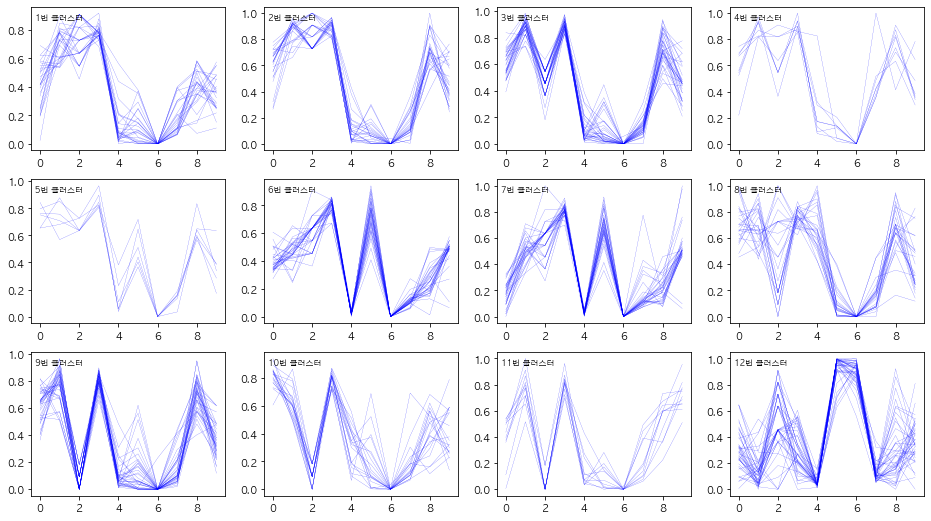

In [64]:
utils.visual_cluster_data(norm_features, kmeans)

# Mail Box Matching

In [65]:
music_label = pd.DataFrame(norm_features['id'])
music_label['label'] = _label

music_label.rename({"id": "track_id"}, axis=1,inplace=True)
music_label.head()

,track_id,label
0,7tIOwGFRTM08JdAeKOELGp,11
1,3UPjb91Fwm7u2tAm92Bk0p,5
2,3dbLT62Cvs46Ju7a8gpr36,1
3,2FWquqPNxte8iqZ3ATQG0p,0
4,3gzIK2dGSVvPBiohsTwEWZ,8


In [66]:
_mail_boxes = db.mail_box.find()
mail_boxes = [_ for _ in _mail_boxes]

mail_box_radar = pd.DataFrame(columns=set(_label))

for target_mail_box in mail_boxes:
    target = pd.DataFrame(target_mail_box['tracks'])
    target_label_info = pd.merge(target, music_label,
        on='track_id')
    group_cnt = target_label_info.groupby(['label']).count()['track_id']
    
    mail_box_radar.loc[str(target_mail_box['_id'])] = (group_cnt / len(target_label_info) * 100).round().astype("int")
    
mail_box_radar.fillna(0, inplace=True)
mail_box_radar = mail_box_radar.astype("int")
mail_box_radar.head()

,0,1,2,3,4,5,6,7,8,9,10,11
623f2515ff1c441a392ab38c,0,0,0,0,0,0,0,0,0,0,0,100
623f2515ff1c441a392ab38d,0,6,0,0,0,50,44,0,0,0,0,0
623f2515ff1c441a392ab38e,0,0,0,0,0,40,10,0,0,0,0,50
623f2515ff1c441a392ab38f,0,6,11,0,0,56,28,0,0,0,0,0
623f2515ff1c441a392ab390,14,14,0,0,0,0,0,71,0,0,0,0


In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
 
## 데이터 준비
df = pd.DataFrame({
'Character': ['Barbarian','Amazon','Necromancer','Sorceress','Paladin'],
'Strength': [10, 5, 3, 2, 7],
'Dexterity': [4, 10, 3, 3, 8],
'Vitality': [9, 9, 7, 7, 8],
'Energy': [4, 4, 10, 10, 6],
'Wisdom': [2, 6, 8, 9, 8]
})

In [68]:
df.head()

,Character,Strength,Dexterity,Vitality,Energy,Wisdom
0,Barbarian,10,4,9,4,2
1,Amazon,5,10,9,4,6
2,Necromancer,3,3,7,10,8
3,Sorceress,2,3,7,10,9
4,Paladin,7,8,8,6,8


In [69]:
def getRadianFromAngle(angle):
    return pi / 180 * angle


def getX(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.cos(rad)

def getY(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.sin(rad)

In [70]:
mail_box_radar = mail_box_radar + 0.1

ValueError: num must be 1 <= num <= 14, not 15

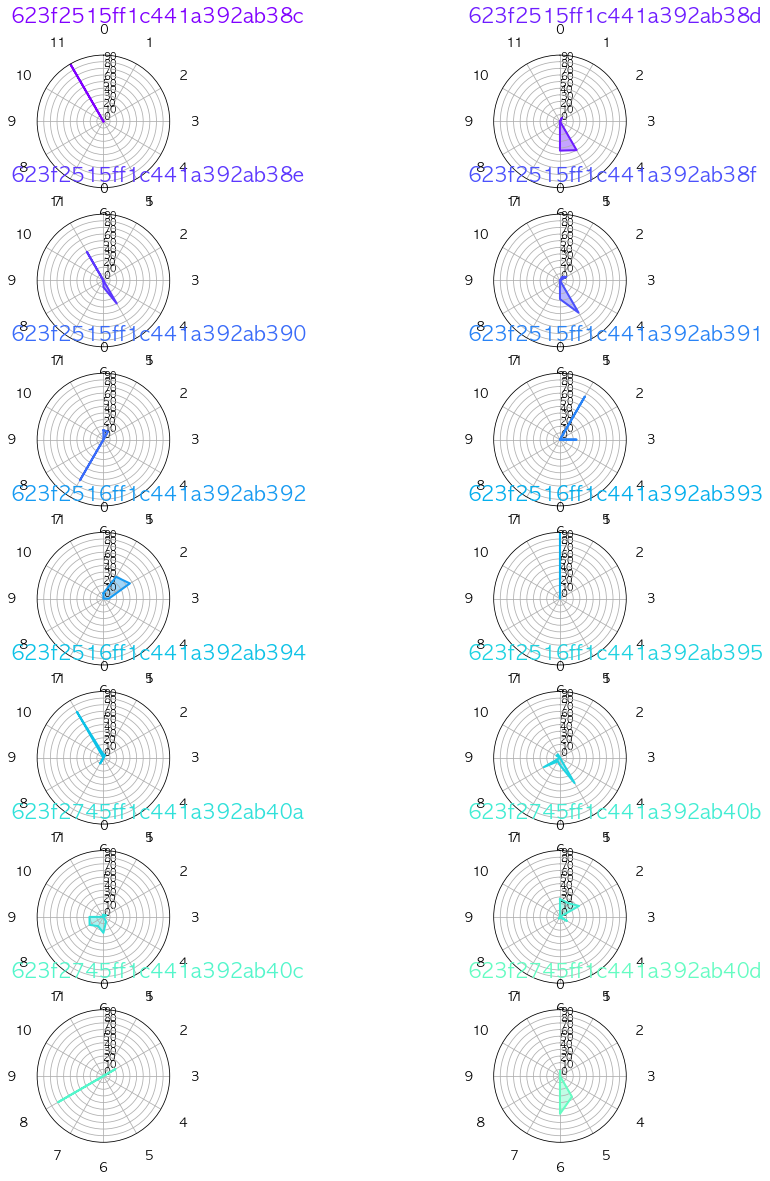

In [72]:
## 따로 그리기
labels = mail_box_radar.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
 
for i, row in enumerate(mail_box_radar.values):
    color = my_palette(i)
    data = row.tolist()
    data += data[:1] # 원점 데이터
    
    ax = plt.subplot(round(K/ 2) + 1,2,i+1, polar=True)
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,100)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
    plt.title(mail_box_radar.index[i], size=20, color=color,x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.
 
plt.tight_layout(pad=5) ## subplot간 패딩 조절
plt.show()

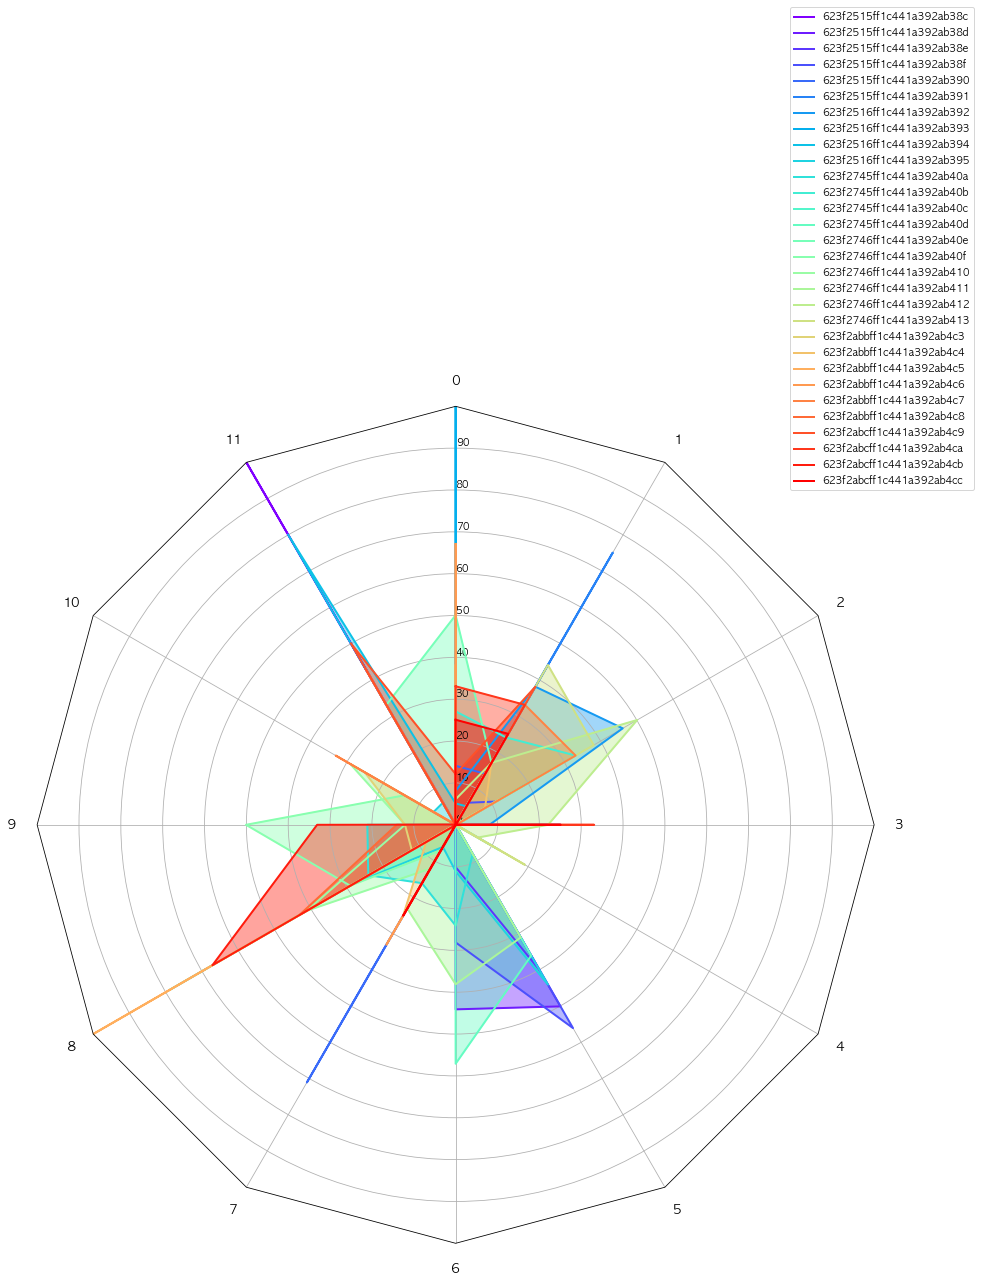

In [73]:
## 따로 그리기
labels = mail_box_radar.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
ax = fig.add_subplot(polar=True)

for i, row in enumerate(mail_box_radar.values):
    color = my_palette(i)
    data = row.tolist()
    data += data[:1] # 원점 데이터
    
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,100)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid',
            label=mail_box_radar.index[i]) ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
for g in ax.yaxis.get_gridlines(): ## grid line 
    g.get_path()._interpolation_steps = len(labels)
    
spine = Spine(axes=ax,
          spine_type='circle',
          path=Path.unit_regular_polygon(len(labels)))
 
## Axes의 중심과 반지름을 맞춰준다.
spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)
           
ax.spines = {'polar':spine} ## frame의 모양을 원에서 폴리곤으로 바꿔줘야한다.
 
plt.legend(loc=(0.9,0.9))
plt.show()

In [74]:
quadrant_check = [[1, 1], [1, -1],[-1, -1], [-1,1]]

def get_quadrant(angle):
    chk_angle = [0, 90, 180, 270]
    if angle in chk_angle:
        return -1
    else:
        if angle < 90:
            return 0
        elif angle < 180:
            return 1
        elif angle < 270:
            return 2
        elif angle < 360:
            return 3
        
def check_guadrant(angle, point):
    if angle == 0:
        return [0, point[1]]
    elif angle == 90:
        return [point[1],0]
    elif angle == 180:
        return [0, point[1] * -1]
    elif angle == 270:
        return [point[1] * -1, 0]


In [75]:
cent_points = list()
mail_box_ids = mail_box_radar.index.values
for b_id in mail_box_ids:
    test = mail_box_radar.loc[b_id]
    non_zero_labels = test != 0

    sel_idx = test[non_zero_labels].index.values
    x = np.array(angles)[sel_idx]
    y = test[sel_idx].values
    
    point = np.array([[x[i], y[i]] for i,_ in enumerate(x)])
    
    point = point.reshape(-1, 2)

    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            ang = ang % 90
            rad = ang * pi / 180
            
            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]
            
            point[idx] = [x,y]
    point = point.reshape(-1, 2)
    point = point.reshape(-1, 2)
    
    cent_points.append(point.sum(axis=0))
    
cent_points = np.array(cent_points)

cent_points

array([[-5.00000000e+01,  8.66025404e+01],
       [ 3.01961524e+01, -8.43012702e+01],
       [-5.00000000e+00, -1.33974596e+00],
       [ 3.86961524e+01, -6.39711432e+01],
       [-4.93634480e+01, -1.45000000e+01],
       [ 8.99519053e+01,  3.75000000e+01],
       [ 6.39089653e+01,  6.68371686e+01],
       [-6.93889390e-17,  1.00000000e+02],
       [-4.43301270e+01,  7.17820323e+01],
       [-5.39230485e+00, -6.81576766e+01],
       [-4.03564065e+01, -5.23826859e+01],
       [ 4.50788383e+01,  6.00788383e+01],
       [-2.90000000e+01, -5.02294734e+01],
       [ 1.80000000e+01, -8.11769145e+01],
       [-1.77756814e+00,  8.70788383e+01],
       [-8.26865335e+01, -2.16147367e+01],
       [-6.50070416e+01, -2.18108891e+01],
       [-4.41858429e+00, -6.83467875e+01],
       [ 6.69185843e+01,  5.48012702e+01],
       [ 7.35596004e+01,  4.54089653e+01],
       [-3.36506351e+01,  5.05000000e+01],
       [-2.79282032e+01,  3.23730670e+01],
       [-5.00000000e+01, -8.66025404e+01],
       [-2.

In [76]:
max_point = np.identity(len(mail_box_radar.columns)) * 100

angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
datas = max_point
cent_max_point = np.array([])

for data in datas:
    point = np.array([[angles[_], data[_]] for _ in range(0, len(data))])
    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            ang = ang % 90
            rad = ang * pi / 180

            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]

            point[idx] = [x,y]
    
    cent_max_point = np.append(cent_max_point,point.sum(axis=0))
    
cent_max_point = cent_max_point.reshape(-1, 2)
cent_max_point

array([[   0.        ,  100.        ],
       [  86.60254038,   50.        ],
       [  50.        ,   86.60254038],
       [ 100.        ,    0.        ],
       [  86.60254038,  -50.        ],
       [  50.        ,  -86.60254038],
       [   0.        , -100.        ],
       [ -86.60254038,  -50.        ],
       [ -50.        ,  -86.60254038],
       [-100.        ,    0.        ],
       [ -86.60254038,   50.        ],
       [ -50.        ,   86.60254038]])

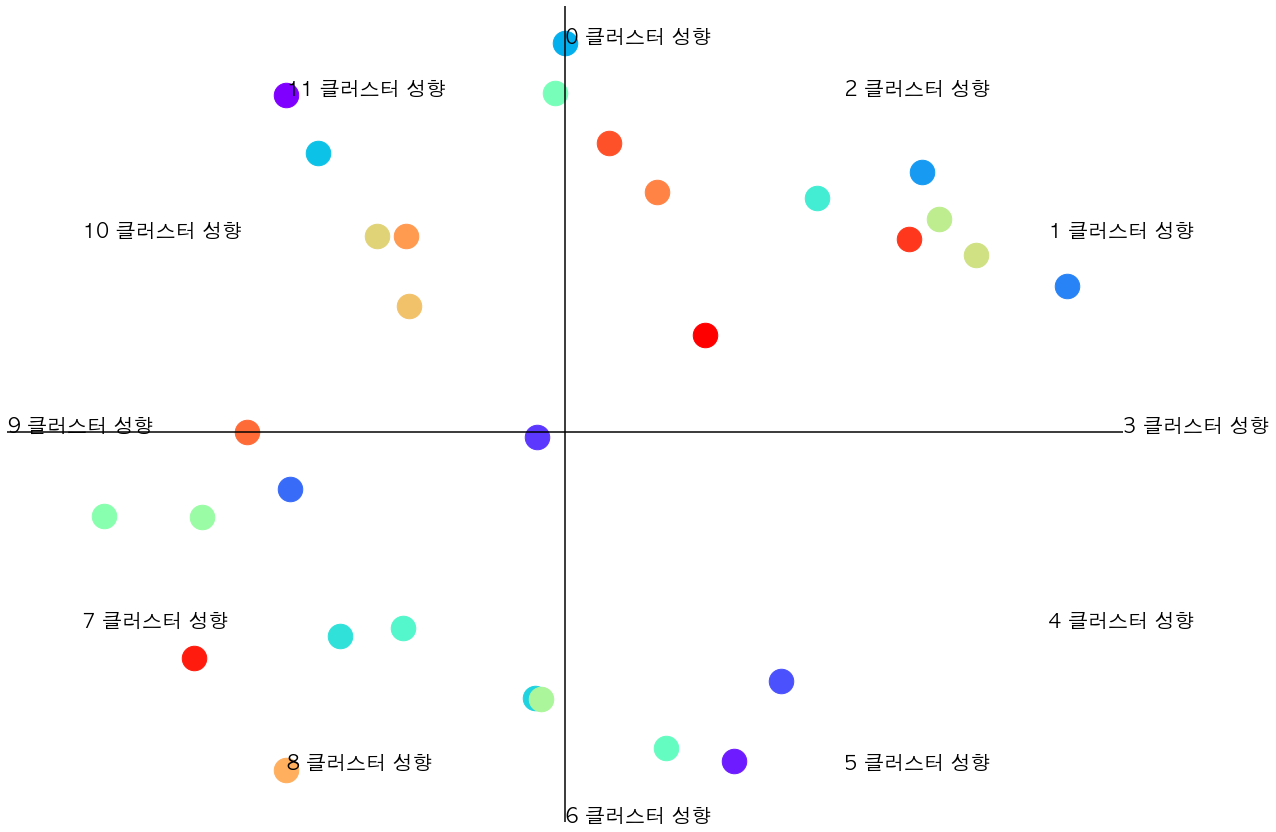

In [77]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(cent_points):
    color = my_palette(idx)
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color=color, label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [78]:
mail_box_points = pd.DataFrame(cent_points, columns=['x','y'])

mail_box_points.index = mail_box_ids
mail_box_points

,x,y
623f2515ff1c441a392ab38c,-5.000000e+01,86.602540
623f2515ff1c441a392ab38d,3.019615e+01,-84.301270
623f2515ff1c441a392ab38e,-5.000000e+00,-1.339746
623f2515ff1c441a392ab38f,3.869615e+01,-63.971143
623f2515ff1c441a392ab390,-4.936345e+01,-14.500000
623f2515ff1c441a392ab391,8.995191e+01,37.500000
623f2516ff1c441a392ab392,6.390897e+01,66.837169
623f2516ff1c441a392ab393,-6.938894e-17,100.000000
623f2516ff1c441a392ab394,-4.433013e+01,71.782032
623f2516ff1c441a392ab395,-5.392305e+00,-68.157677


# 유사도 확인

In [79]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[0].name
user_centroid = mail_box_points.iloc[0].values
user_x, user_y = user_centroid

search_box = mail_box_points[
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
]

search_box.head()

,x,y
623f2515ff1c441a392ab38c,-5.000000e+01,86.602540
623f2515ff1c441a392ab38e,-5.000000e+00,-1.339746
623f2516ff1c441a392ab393,-6.938894e-17,100.000000
623f2516ff1c441a392ab394,-4.433013e+01,71.782032
623f2745ff1c441a392ab40b,4.507884e+01,60.078838


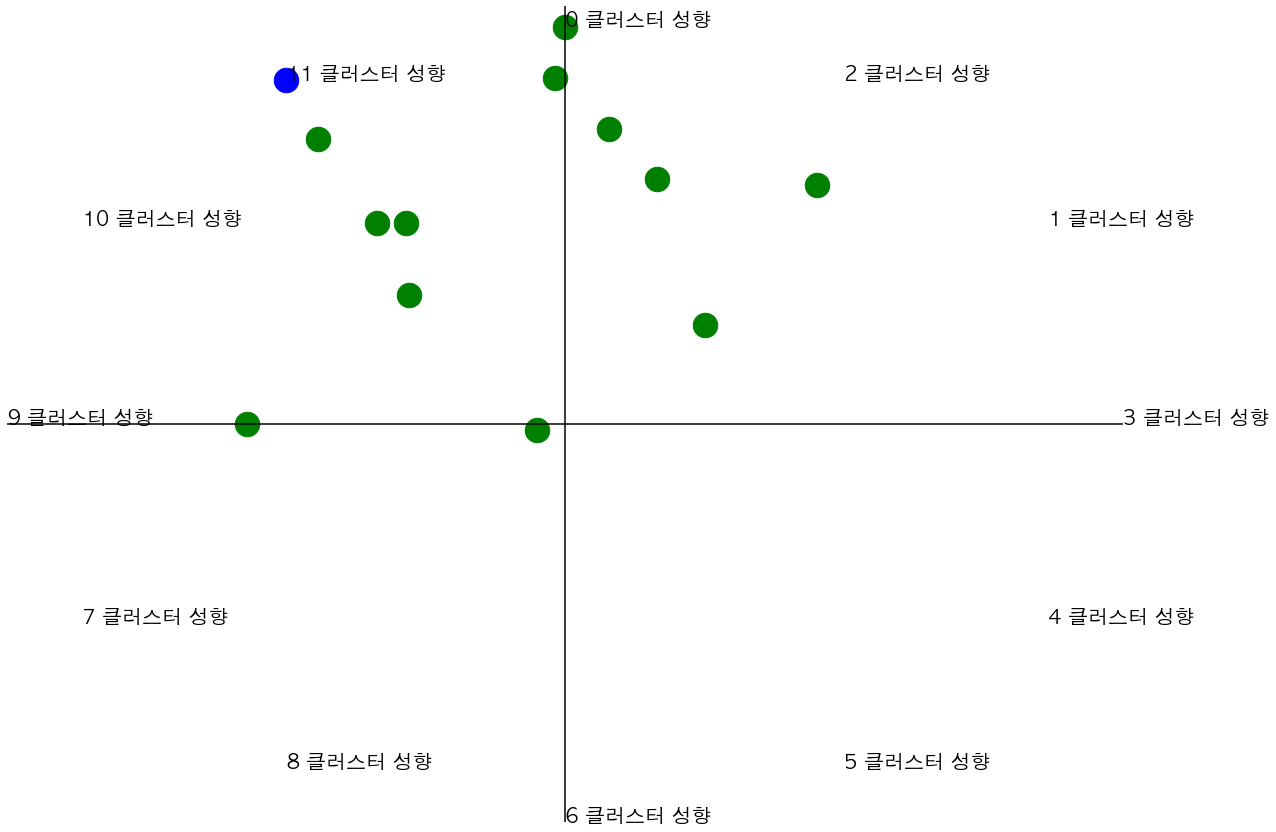

In [80]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [81]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [82]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.532374,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.108152,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38e,0.532374,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.108152,0.357399,0.426436
2,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab394,0.532374,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.108152,0.357399,0.426436
3,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2746ff1c441a392ab40e,0.532374,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.108152,0.357399,0.426436
4,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2abbff1c441a392ab4c4,0.532374,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.108152,0.357399,0.426436


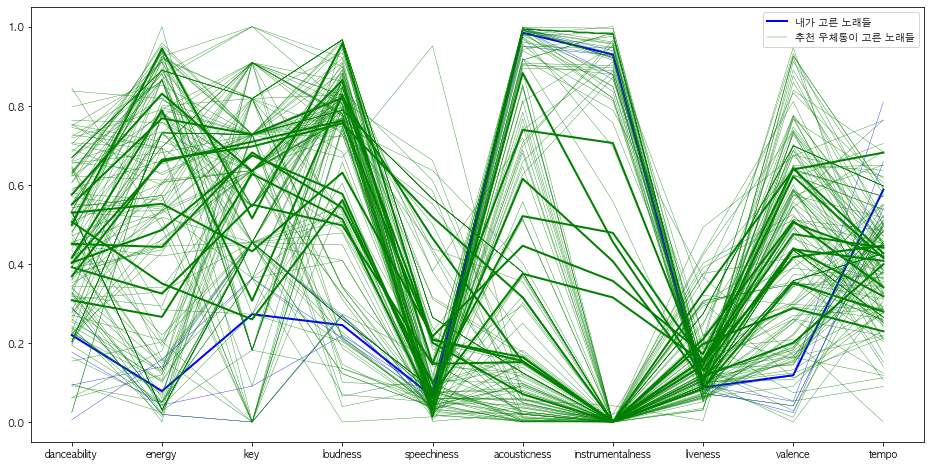

In [83]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [84]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.36033250531193


In [85]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[0].name
user_centroid = mail_box_points.iloc[0].values
user_x, user_y = user_centroid

search_box = mail_box_points[~(
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
)]

search_box = search_box.append(mail_box_points.iloc[0])

search_box.head()

,x,y
623f2515ff1c441a392ab38d,30.196152,-84.301270
623f2515ff1c441a392ab38f,38.696152,-63.971143
623f2515ff1c441a392ab390,-49.363448,-14.500000
623f2515ff1c441a392ab391,89.951905,37.500000
623f2516ff1c441a392ab392,63.908965,66.837169


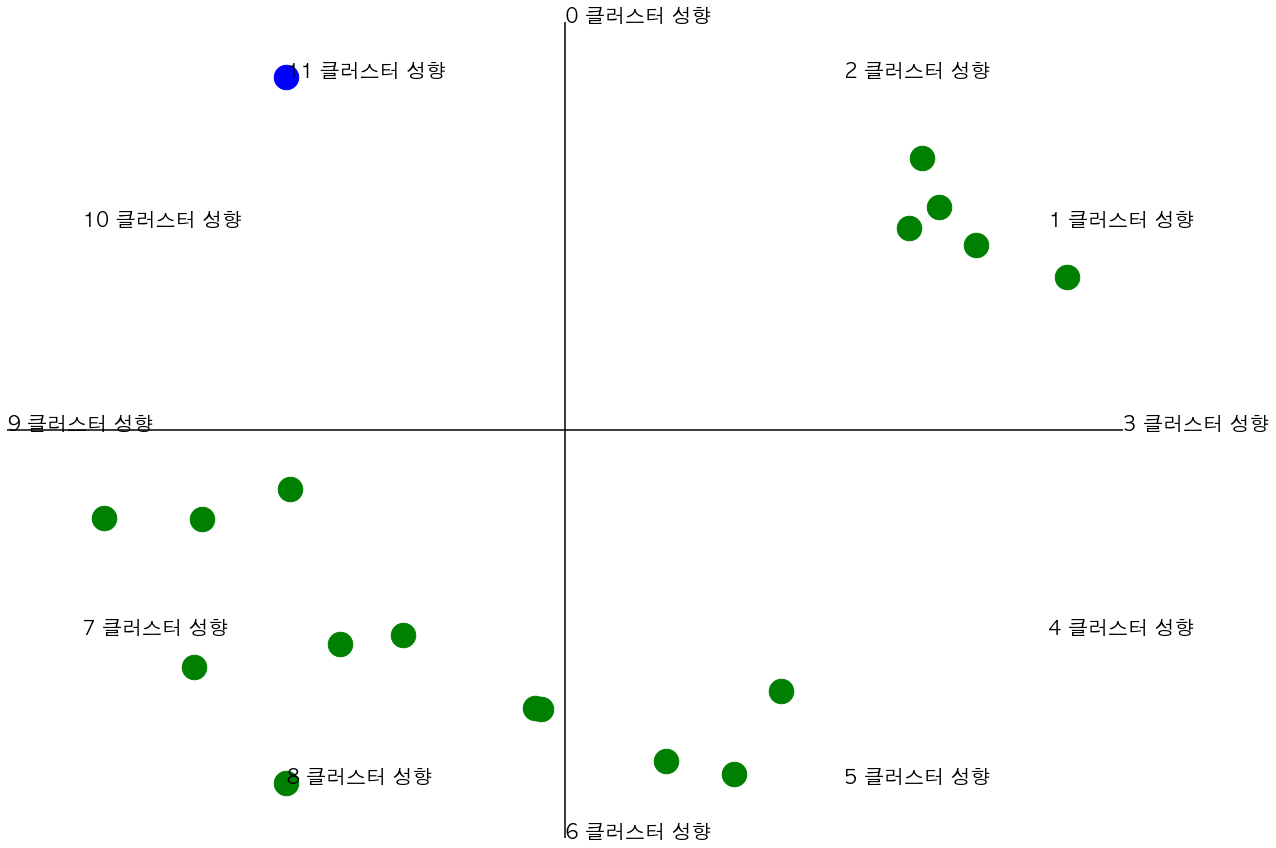

In [86]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [87]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [88]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.532374,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.108152,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab395,0.532374,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.108152,0.357399,0.426436
2,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c,0.093525,0.140150,0.454545,0.265490,0.036117,0.949746,0.927597,0.081774,0.117103,0.809968
3,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c,0.176978,0.042931,0.090909,0.219294,0.071465,0.994975,0.939140,0.083155,0.023921,0.540853
4,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c,0.290647,0.019239,0.000000,0.269312,0.070697,0.991959,0.922350,0.072478,0.040883,0.503742


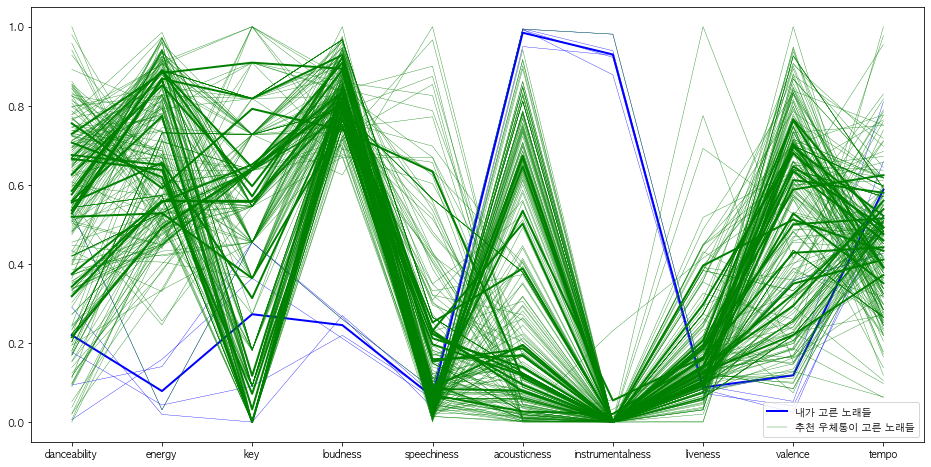

In [89]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [90]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.6277974284644814
